# Anomaly Detection


In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
import seaborn as sns
from pylab import rcParams
from sklearn.utils import shuffle
from pdb import set_trace
import matplotlib.pylab as plt
import sys
from sklearn.preprocessing import MinMaxScaler

In [2]:
sys.path.append('/home/aggelos-i3/ForecastingLib/')
from tsutils import SequenceSpliter
from utils import utilities

In [3]:
rcParams['figure.figsize'] = 11, 7
sns.set()

In [4]:
LOOKBACK = 100
LOOK_AHEAD = 1
features = len(['acceleration (actual) [m/(s*s)]', 'voltage [V]', 'energy balance[kWh]'])
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')

In [12]:
df =pd.read_csv("/home/aggelos-i3/Downloads/simu Elbas/7h33NO/7hnz0037.xls" ,delimiter='\t')

In [5]:
df_normal_voltage = pd.DataFrame()
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t')
    df = df[['voltage [V]']][:1000].transpose()
    #df = df.set_index("loc. (actual) [km]")
    # df.dropna(inplace=True)
    # df.sort_index(inplace=True)
    if df_normal_voltage.empty:
        df_normal_voltage = df
    else:
        df_normal_voltage = df_normal_voltage.append(df)
#taking the average of all values for each timestep
avg_normal = df_normal_voltage.mean(axis=0)

# Tail-rolling average transform
rolling_mean = avg_normal.rolling(window=10).mean()



In [ ]:
def get_rolling_average(df, feature):
    df = df[[feature]][:1000].transpose()
    

In [6]:
#i will do the same for the acceleration
df_normal_acceleration = pd.DataFrame()
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t')
    df = df[['acceleration (actual) [m/(s*s)]']][:1000].transpose()
    #df = df.set_index("loc. (actual) [km]")
    # df.dropna(inplace=True)
    # df.sort_index(inplace=True)
    if df_normal_acceleration.empty:
        df_normal_acceleration = df
    else:
        df_normal_acceleration = df_normal_acceleration.append(df)
    df_normal_acceleration['label'] = np.zeros(
        (len(df_normal_acceleration), 1)).astype(int)

avg_normal_acceleration = df_normal_acceleration.drop("label",
                                                      axis=1).mean(axis=0)
rolling_acc = avg_normal_acceleration.rolling(window=10)
rolling_mean_acc = rolling_acc.mean()

#rolling_mean_acc.plot()

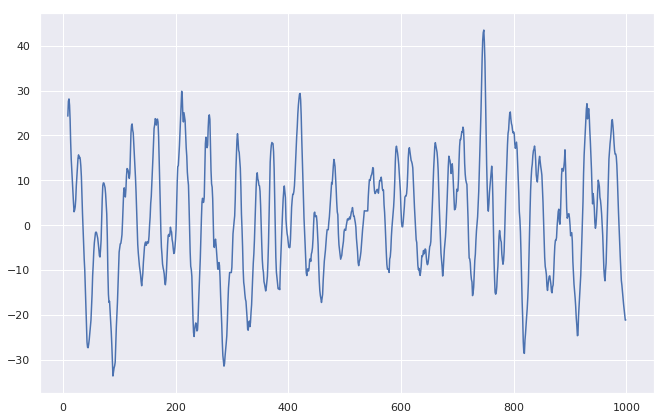

In [7]:
#i will do the same for the tractive effort
df_normal_tractive_eff = pd.DataFrame()
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t')
    df = df[['tractive effort (actual) [kN]']][:1000].transpose()
    #df = df.set_index("loc. (actual) [km]")
    # df.dropna(inplace=True)
    # df.sort_index(inplace=True)
    if df_normal_tractive_eff.empty:
        df_normal_tractive_eff = df
    else:
        df_normal_tractive_eff = df_normal_tractive_eff.append(df)
    df_normal_tractive_eff['label'] = np.zeros(
        (len(df_normal_tractive_eff), 1)).astype(int)

avg_normal_tractive_eff = df_normal_tractive_eff.drop("label",
                                                      axis=1).mean(axis=0)
rolling_tract_eff = avg_normal_tractive_eff.rolling(window=10)
rolling_mean_tract_eff = rolling_tract_eff.mean()
plt.plot(rolling_mean_tract_eff)

In [8]:
#i will do the same for the distance
df_normal_distance = pd.DataFrame()
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t')
    df = df[['loc. (actual) [km]']][:1000].transpose()
    #df = df.set_index("loc. (actual) [km]")
    # df.dropna(inplace=True)
    # df.sort_index(inplace=True)
    if df_normal_distance.empty:
        df_normal_distance = df
    else:
        df_normal_distance = df_normal_distance.append(df)
    df_normal_distance['label'] = np.zeros(
        (len(df_normal_distance), 1)).astype(int)

avg_normal_distance = df_normal_distance.drop("label", axis=1)
distance = avg_normal_distance.iloc[0]  #not average but will do

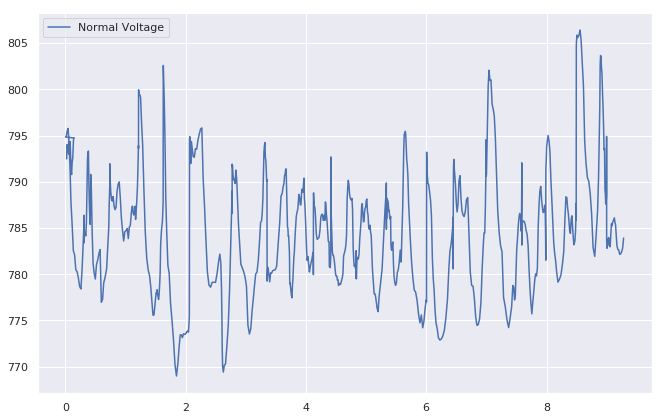

In [9]:
plt.plot(distance, rolling_mean, label='Normal Voltage')
#plt.plot(distance, rolling_voltage_abnormal, label='Abnormal Voltage')
plt.legend(loc='best')

In [202]:
df = pd.DataFrame({
    'Voltage': rolling_mean,
    'Acceleration': rolling_mean_acc,
    "Location": distance,
    "Tract_effort": rolling_mean_tract_eff,
})
df = df.dropna()

In [203]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)
spliter = SequenceSpliter(lookback=LOOKBACK, look_ahead=LOOK_AHEAD)

In [204]:
X, y = spliter.fit_transform(df_scaled)

In [205]:
X = X[:, :, 1:]
# we need to forecast only the voltage
y = y[:, :, 0]

In [206]:
# now we will build our simple forecasting model
inputs = Input(shape=(X.shape[1:]))
q = LSTM(LOOKBACK)(inputs)
q = Dropout(0.8)(q)
x = Conv1D(256, kernel_size=32, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(32, kernel_size=32, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(16, kernel_size=32, padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = concatenate([inputs, x])
x = GlobalMaxPooling1D()(x)
z = concatenate([x, q])
z = Dropout(0.8)(z)
outs = Dense(LOOK_AHEAD)(z)
model = tf.keras.Model(inputs, outs)
model.compile(loss='mse', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 200, 3)       0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 200, 256)     24832       input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 200, 256)     1024        conv1d_27[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 200, 256)     0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
conv1d_28 

Train on 711 samples, validate on 80 samples
Epoch 1/5
711/711 [==============================] - 10s 14ms/step - loss: 1.4971 - val_loss: 1.1203
Epoch 2/5
711/711 [==============================] - 7s 10ms/step - loss: 1.0429 - val_loss: 0.7941
Epoch 3/5
711/711 [==============================] - 7s 10ms/step - loss: 0.9136 - val_loss: 0.8949
Epoch 4/5
711/711 [==============================] - 7s 10ms/step - loss: 0.7963 - val_loss: 0.7585
Epoch 5/5
711/711 [==============================] - 7s 10ms/step - loss: 0.6720 - val_loss: 0.8923


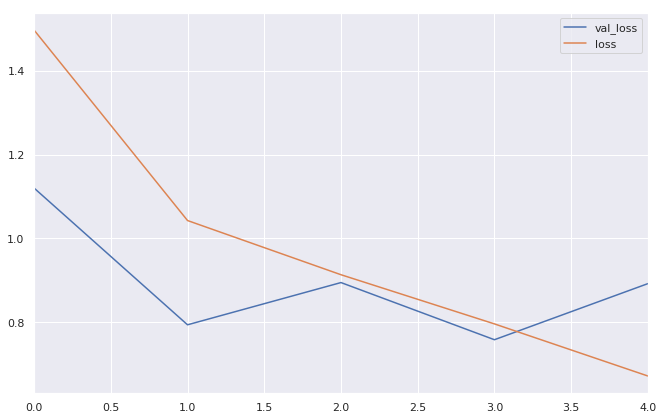

In [207]:
history = model.fit(X, y, epochs=5, validation_split=0.1)
history = pd.DataFrame(history.history)
history.plot()

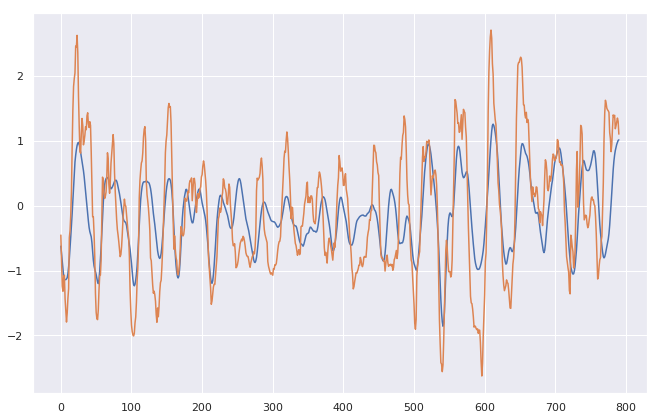

In [208]:
plt.plot(model.predict(X))
plt.plot(y)

In [209]:
model.save_weights('model_weights.h5')

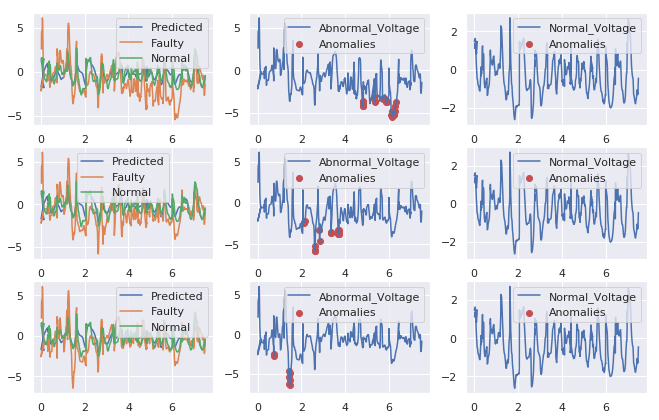

In [210]:
ERROR_TYPE = [1, 2, 3] #we can hav different labels for each error or the same label??
STD_MPL = 5
labels = []
train_set = []
#train_set.append(X)
label_0 = np.zeros((X.shape[0]))
#labels.append(label_0)
classifiers = []

PLOT_IDX = 5
rows = 3
i=1 # for plots
for DATASET_IDX in range(0,19):
    for error_type in ERROR_TYPE:
        df_error_voltage = pd.DataFrame()
        df_error_acceleration = pd.DataFrame()
        df_abnormal_tractive_eff = pd.DataFrame()

        pathlist = Path(f"/home/aggelos-i3/Downloads/simu Elbas/7h33D{error_type}").glob(
            '**/*.xls')
        for path in pathlist:
            # because path is object not string
            path_in_str = str(path)
            df = pd.read_csv(path_in_str, delimiter='\t')
            
            
            df1 = df[['voltage [V]']][:1000].transpose()
            if df_error_voltage.empty:
                df_error_voltage = df1
            else:
                df_error_voltage = df_error_voltage.append(df1)

            #i will do the same for the acceleration
            df2 = df[['acceleration (actual) [m/(s*s)]']][:1000].transpose()
            if df_error_acceleration.empty:
                df_error_acceleration = df2
            else:
                df_error_acceleration = df_error_acceleration.append(df2)


            #i will do the same for the tractive effort
            df3 = df[['tractive effort (actual) [kN]']][:1000].transpose()
            if df_abnormal_tractive_eff.empty:
                df_abnormal_tractive_eff = df3
            else:
                df_abnormal_tractive_eff = df_abnormal_tractive_eff.append(df3)
 
        

        rolling_voltage_abnormal = df_error_voltage.iloc[DATASET_IDX].rolling(window=10).mean()
        rolling_acc_abnormal = df_error_acceleration.iloc[DATASET_IDX].rolling(window=10).mean()
        mean_rolling_tract_eff_abnormal = df_abnormal_tractive_eff.iloc[DATASET_IDX].rolling(window=10).mean()



        df_faulty = pd.DataFrame({
            "Voltage": rolling_voltage_abnormal,
            "Acceleration": rolling_acc_abnormal,
            "Location": distance,
            "Tract_effort": mean_rolling_tract_eff_abnormal
        })
        df_faulty.dropna(inplace=True)
        df_scaled_faulty = scaler.transform(df_faulty)
        X_test, y_test = spliter.fit_transform(df_scaled_faulty)
        #_test = X_test[:, :, 1:]
        y_test = y_test[:, :, 0]

        yhat = model.predict(X_test[:,:,1:])
        
        if DATASET_IDX==PLOT_IDX:
            plt.subplot(3,3,i)
            plt.plot(distance[-len(yhat):], yhat, label='Predicted')
            plt.plot(distance[-len(yhat):], y_test, label='Faulty')
            plt.plot(distance[-len(yhat):], y, label='Normal')
            plt.legend(loc='best')

        yhat = yhat.reshape(yhat.shape[0]) 
        y_ = y.reshape(y.shape[0])
        y_test = y_test.reshape(y_test.shape[0]) 

        anomaly = y_test < yhat - STD_MPL * yhat.std()
        label = anomaly.astype(int) * 1
        labels.append(label)
        
        if DATASET_IDX ==PLOT_IDX:
            plt.subplot(3,3,i+1)
            plt.plot(distance[-len(yhat):], y_test, label='Abnormal_Voltage')
            plt.scatter(distance[-len(yhat):],
                        np.where(anomaly, y_test, None),
                        c='r',
                        label='Anomalies')
            plt.legend(loc='best')

            anomaly = y_ < yhat - STD_MPL * yhat.std()
            plt.subplot(3,3,i+2)
            plt.plot(distance[-len(yhat):], y_, label='Normal_Voltage')
            plt.scatter(distance[-len(yhat):],
                        np.where(anomaly, y_, None),
                        c='r',
                        label='Anomalies')
            plt.legend(loc='best')
            i += 3
        train_set.append(X_test)
        
        

In [211]:
#dataset preprocessing ofr classification training
from sklearn.model_selection import train_test_split
labels = np.array(labels).reshape(-1,1)
train_set = np.array(train_set)
train_set = train_set.reshape(train_set.shape[0] * train_set.shape[1], train_set.shape[2], train_set.shape[3])
idx = np.random.permutation(len(train_set))
X,Y = train_set[idx], labels[idx]
train_X, test_X, train_y, test_y = train_test_split(X, Y)


In [176]:
# Kfold
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels


def create_model():
    model = tf.keras.models.Sequential()
    model.add(Conv1D(256, 32, padding='same', input_shape=(LOOKBACK, features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(128,32, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(128,32, padding='same'))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='RMSProp',
                  metrics=['accuracy'])
    return model


sk_model = KerasClassifier(build_fn=create_model,
                           epochs=40,
                           batch_size=64,
                           verbose=0)

In [212]:
# now we will build our simple forecasting model
inputs = Input(shape=(X.shape[1:]))
q = LSTM(LOOKBACK)(inputs)
q = Dropout(0.8)(q)
x = Conv1D(256, kernel_size=32, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(32, kernel_size=32, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(16, kernel_size=32, padding='same')(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = concatenate([inputs, x])
x = GlobalMaxPooling1D()(x)
z = concatenate([x, q])
z = Dropout(0.8)(z)
outs = Dense(2, activation='softmax')(z)
tf_model = tf.keras.Model(inputs, outs)
tf_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam')
tf_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200, 4)       0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 200, 256)     33024       input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 200, 256)     1024        conv1d_30[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 200, 256)     0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
conv1d_31 

In [213]:
#undersampling of majority class
from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
rus = RandomUnderSampler()
x_ = train_X.reshape(train_X.shape[0], train_X.shape[1] * train_X.shape[2])
x_res, y_res = rus.fit_resample(x_,train_y)
x_res = x_res.reshape(x_res.shape[0], LOOKBACK, 4)


#sk_model.fit(x_res, y_res)
history = tf_model.fit(x_res, y_res, validation_split=0.1, epochs =40)

Train on 1845 samples, validate on 205 samples
Epoch 1/40
1845/1845 [==============================] - 21s 11ms/step - loss: 0.7133 - val_loss: 0.2326
Epoch 2/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.4835 - val_loss: 0.2648
Epoch 3/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.3534 - val_loss: 0.1747
Epoch 4/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.3134 - val_loss: 0.2894
Epoch 5/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.2882 - val_loss: 0.1338
Epoch 6/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.2739 - val_loss: 0.1517
Epoch 7/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.2372 - val_loss: 0.1266
Epoch 8/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.2261 - val_loss: 0.1429
Epoch 9/40
1845/1845 [==============================] - 18s 10ms/step - loss: 0.2069 - val_loss: 0.1110
Epoch 10/40
1845/

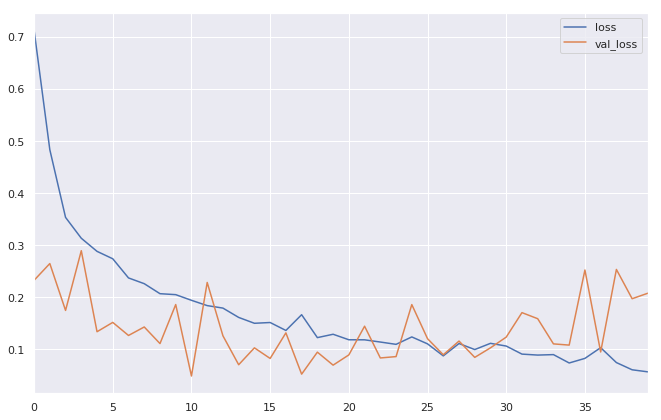

In [214]:
history = pd.DataFrame(history.history)
history[['loss', 'val_loss']].plot()

In [215]:
predictions = np.argmax(tf_model.predict(test_X), axis=1)


In [216]:
print(f"Accuracy: {accuracy_score(test_y, predictions)*100}%")
print(f"Recall: {recall_score(test_y, predictions)*100}%")
print(f"Precision: {precision_score(test_y, predictions)*100}%")
print(f"Accuracy: {accuracy_score(test_y, predictions)*100}%")
print(f"Recall: {recall_score(test_y, predictions)*100}%")
print(f"ROC: {roc_auc_score(test_y, predictions)}")

Accuracy: 94.97870830376152%
Recall: 97.0414201183432%
Precision: 37.10407239819005%
Accuracy: 94.97870830376152%
Recall: 97.0414201183432%
ROC: 0.9597818216453102


In [217]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [218]:
class_names = np.array(['Normal', 'D1 Error', 'D2 error', 'D3 error'])


In [219]:
kf = KFold(5)
preds = []
true = []
for train_idx, test_idx in kf.split(x_res, y_res):
    #print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test = x_res[train_idx], x_res[test_idx]
    y_train, y_test = y_res[train_idx], y_res[test_idx]
    tf_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam')
    tf_model.fit(X_train, y_train, epochs=30, verbose=2)
    y_hat = tf_model.predict(X_test)
    preds.append(np.argmax(y_hat, axis=1))
    true.append(np.array(y_test).reshape(-1,)) 


#preds = preds.reshape(-1,1)

Epoch 1/30
 - 22s - loss: 0.0923
Epoch 2/30
 - 19s - loss: 0.1009
Epoch 3/30
 - 19s - loss: 0.0781
Epoch 4/30
 - 19s - loss: 0.0874
Epoch 5/30
 - 19s - loss: 0.0897
Epoch 6/30
 - 19s - loss: 0.0883
Epoch 7/30
 - 19s - loss: 0.0718
Epoch 8/30
 - 19s - loss: 0.0665
Epoch 9/30
 - 19s - loss: 0.0576
Epoch 10/30
 - 19s - loss: 0.0436
Epoch 11/30
 - 18s - loss: 0.0554
Epoch 12/30
 - 19s - loss: 0.0546
Epoch 13/30
 - 18s - loss: 0.0636
Epoch 14/30
 - 18s - loss: 0.0891
Epoch 15/30
 - 18s - loss: 0.0697
Epoch 16/30
 - 16s - loss: 0.0408
Epoch 17/30
 - 17s - loss: 0.0468
Epoch 18/30
 - 16s - loss: 0.0440
Epoch 19/30
 - 15s - loss: 0.0358
Epoch 20/30
 - 15s - loss: 0.0470
Epoch 21/30
 - 15s - loss: 0.0724
Epoch 22/30
 - 15s - loss: 0.0598
Epoch 23/30
 - 15s - loss: 0.0534
Epoch 24/30
 - 16s - loss: 0.0479
Epoch 25/30
 - 16s - loss: 0.0391
Epoch 26/30
 - 18s - loss: 0.0448
Epoch 27/30
 - 15s - loss: 0.0503
Epoch 28/30
 - 16s - loss: 0.0358
Epoch 29/30
 - 16s - loss: 0.0461
Epoch 30/30
 - 16s - lo

Normalized confusion matrix
[[0.96585366 0.03414634]
 [0.01073171 0.98926829]]


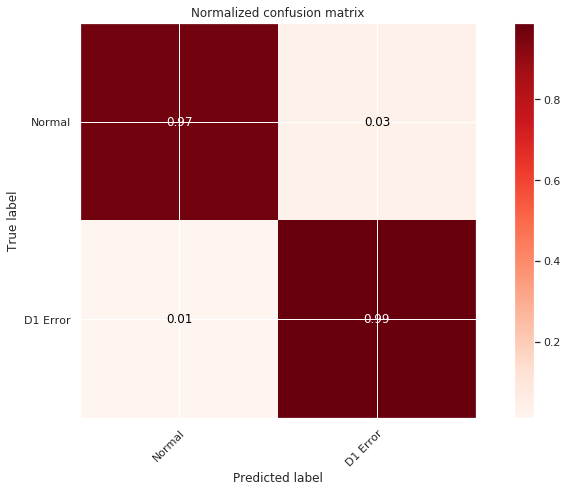

In [220]:
true_ = np.concatenate(true, axis=0)

preds_ = np.concatenate(preds, axis=0)

plot_confusion_matrix(true_,
                      preds_,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')

In [221]:
from sklearn.metrics import classification_report
report = classification_report(true_, preds_)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1025
           1       0.97      0.99      0.98      1025

   micro avg       0.98      0.98      0.98      2050
   macro avg       0.98      0.98      0.98      2050
weighted avg       0.98      0.98      0.98      2050



In [222]:
#report on full sampled data
kf = KFold(5)
preds = []
true = []
for train_idx, test_idx in kf.split(X, Y):
    #print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]
    #tf_model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSProp')
    #tf_model.fit(X_train, y_train, epochs=50, verbose=2)
    y_hat = tf_model.predict(X_test)
    preds.append(np.argmax(y_hat, axis=1))
    true.append(np.array(y_test).reshape(-1,)) 


Normalized confusion matrix
[[0.95958741 0.04041259]
 [0.01027146 0.98972854]]


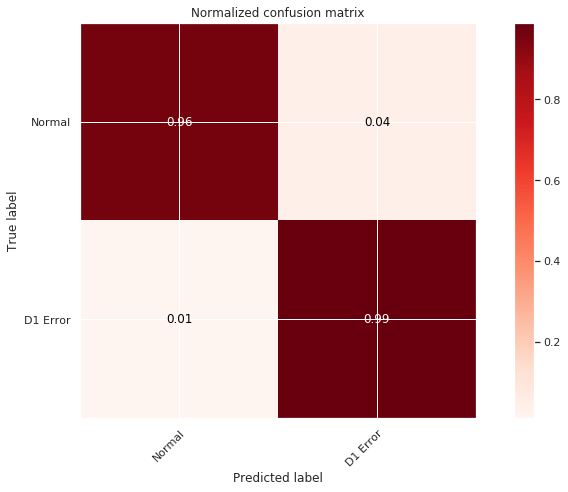

In [230]:
true_ = np.concatenate(true, axis=0)

preds_ = np.concatenate(preds, axis=0)

plot_confusion_matrix(true_,
                      preds_,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')

In [226]:
report = classification_report(true_, preds_)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     43724
           1       0.43      0.99      0.60      1363

   micro avg       0.96      0.96      0.96     45087
   macro avg       0.72      0.97      0.79     45087
weighted avg       0.98      0.96      0.97     45087



In [192]:
tf.keras.models.save_model(tf_model, './models/anomaly_clfr.h5')
from sklearn.externals import joblib
scaler_filename = "./models/scaler.save"
joblib.dump(scaler, scaler_filename) 

['./models/scaler.save']

In [228]:
clf = tf.keras.models.load_model('./models/anomaly_clfr.h5')